In [1]:
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
import cv2 as cv
import os
import pandas as pd
import h5py
import seaborn as sns
import scipy as sc

import statsmodels.api as sm

# Keras
import keras
from keras.models import Sequential
from keras import layers
from keras import optimizers
from keras import backend as K

%matplotlib inline
matplotlib.style.use('ggplot')

matplotlib.rcParams.update({'font.size': 12})
np.set_printoptions(precision = 3, suppress = True)
print('Keras version:', keras.__version__)

Keras version: 2.6.0


In [2]:
data_root = os.path.normpath('.')
hd_file_large = os.path.join(data_root, 'physio.h5')
label_file = os.path.join(data_root, 'REFERENCE-v3.csv')

In [3]:
df = pd.read_csv(label_file, header = None, names = ['name', 'label'])
df_stat = df.groupby('label').agg('count').reset_index()
df_stat.columns = ['label', 'recordings']
df_stat = df_stat.assign(percent = (100 * np.around(df_stat.recordings/df.shape[0], 2)).astype(np.int))
print(df_stat)
df_set = list(df.label.unique())

  label  recordings  percent
0     A         758        9
1     N        5076       60
2     O        2415       28
3     ~         279        3


<ipython-input-3-f7bc89e1113a>:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df_stat = df_stat.assign(percent = (100 * np.around(df_stat.recordings/df.shape[0], 2)).astype(np.int))


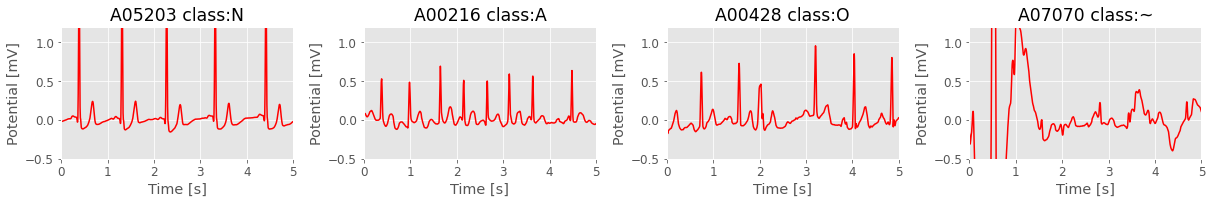

In [4]:
from physionet_processing import fetch_h5data
np.random.seed(148)

# Open large hdf5 file (download https://s3.us-east-2.amazonaws.com/cscie89/physio.h5)
h5file =  h5py.File(hd_file_large, 'r')

dataset_list = list(h5file.keys())

def get_sample():
    fid_list = [np.random.choice(df[df.label == label].name.values, 1)[0] for label in df_set]
    return fid_list

name_list = get_sample()
slen = 1500
idx_list = [dataset_list.index(name) for name in name_list]
data = fetch_h5data(h5file, idx_list, sequence_length = slen)
time = np.arange(0, slen)/300

fig, ax = plt.subplots(1, len(idx_list), figsize = (17, 3))

for i, ax1 in enumerate(ax):
    
    ax1.plot(time, data[i], color = 'r')
    ax1.set(xlim = [0, 5], xticks = np.arange(0, 5.5, 1),
            ylim = [-0.5, 1.2], yticks = np.arange(-0.5, 1.2, 0.5),
            xlabel = 'Time [s]', ylabel = 'Potential [mV]')
    ax1.set_title(name_list[i] + ' class:' + df_set[i])


plt.tight_layout()
plt.show()    
fig.savefig('physionet_classes.png', bbox_inches = 'tight', dpi = 150)

Unique sampling rates in dataset: [300.0]
Unique gain settings in dataset: [1000.0]
Unique baseline settings: [0.0]
Sequence lengths [min, max]: [2714, 18286]
Recording times in seconds [min, max]: [9.047, 60.953]


C:\Users\saibh\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


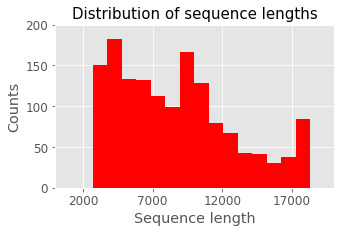

In [5]:
from physionet_processing import special_parameters

sequence_lengths, sampling_rates, recording_times, baselines, gains = special_parameters(h5file)
sequence_length_min, sequence_length_max = np.min(sequence_lengths), np.max(sequence_lengths)
recording_time_min, recording_time_max = np.min(recording_times), np.max(recording_times)

print('Unique sampling rates in dataset:', sampling_rates)
print('Unique gain settings in dataset:', gains)
print('Unique baseline settings:', baselines)
print('Sequence lengths [min, max]:', [sequence_length_min, sequence_length_max])
print('Recording times in seconds [min, max]: [%.3f, %.3f]' %(recording_time_min, recording_time_max))

fig = plt.figure(figsize = (5, 3))
f = sns.distplot(list(sequence_lengths), norm_hist = False, kde = False, color = 'red', hist_kws=dict(alpha=1))
f.set(xlabel = 'Sequence length', xlim = [0, 20000], xticks = np.arange(2000, 20000, 5000))
f.set(ylabel = 'Counts', ylim = [0, 200], yticks = np.arange(0, 250, 50))
plt.title('Distribution of sequence lengths', fontsize=15)
plt.show()
fig.savefig('physionet_sequenceLenHist.png', bbox_inches = 'tight', dpi = 150)

# Based on this, we can set some parameters that we will use in the future
fs = sampling_rates[0] 
sequence_length = sequence_length_max

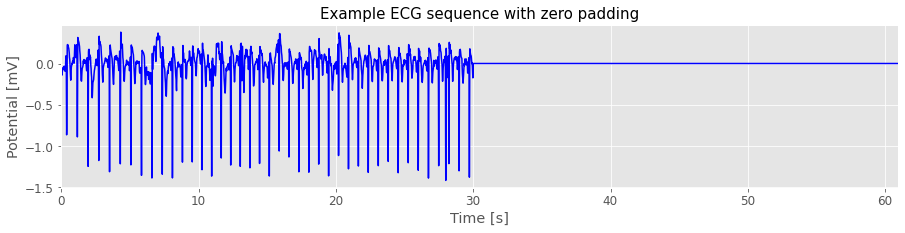

In [6]:
from physionet_processing import extend_ts

ts = h5file[dataset_list[15]]['ecgdata'][:, 0]
ts_extended = extend_ts(ts, length = sequence_length_max)
time = np.arange(0, len(ts_extended))/fs
fig, ax1 = plt.subplots(figsize = (15, 3))
ax1.plot(time, ts_extended, 'b')
ax1.set(xlabel = 'Time [s]', xlim = [0, time[-1]], xticks = np.arange(0, time[-1]+5, 10))
ax1.set(ylabel = 'Potential [mV]')
plt.title('Example ECG sequence with zero padding', fontsize = 15)
fig.savefig('physionet_ECG_padding.png', bbox_inches = 'tight', dpi = 150)
plt.show()

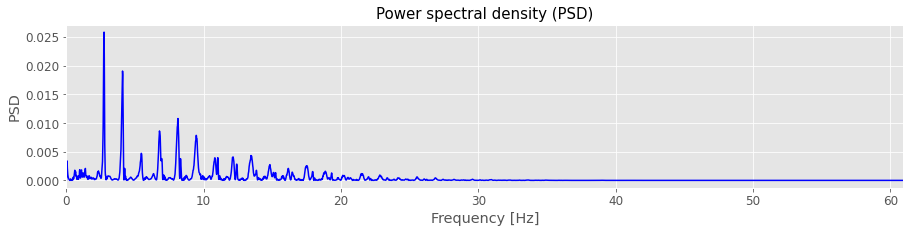

In [7]:
from scipy import signal
f1, PSD = signal.periodogram(ts_extended, fs, 'flattop', scaling = 'density')
fig, ax1 = plt.subplots(figsize = (15, 3))
ax1.plot(f1, PSD, 'b')
ax1.set(xlabel = 'Frequency [Hz]', xlim = [0, time[-1]], xticks = np.arange(0, time[-1]+5, 10))
ax1.set(ylabel = 'PSD')
plt.title('Power spectral density (PSD)', fontsize = 15)
fig.savefig('physionet_ECG_PSD.png', bbox_inches = 'tight', dpi = 150)
plt.show()

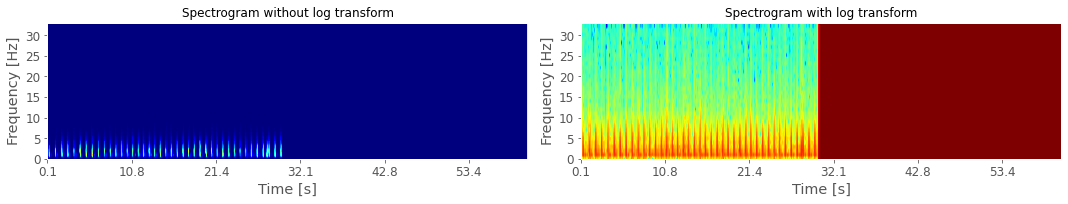

In [8]:
from physionet_processing import spectrogram

Sx = spectrogram(np.expand_dims(ts_extended, axis = 0), log_spectrogram = False)[2]
Sx_log = spectrogram(np.expand_dims(ts_extended, axis = 0), log_spectrogram = True)[2]

f, t, _ = spectrogram(np.expand_dims(ts_extended, axis = 0), log_spectrogram = False) 

im_list = [Sx[0], Sx_log[0]]
im_title = ['Spectrogram without log transform', 'Spectrogram with log transform']
fig, ax_list = plt.subplots(1, 2, figsize = (15, 3))

for i, ax in enumerate(ax_list):
    
    ax.imshow(np.transpose(im_list[i]), aspect = 'auto', cmap = 'jet')
    ax.grid(False)
    ax.invert_yaxis()
    ax.set_title(im_title[i], fontsize = 12)
    ax.set(ylim = [0, im_list[i].shape[1]], yticks = np.arange(0, im_list[i].shape[1] + 1, 5))
    ax.set(xlabel = 'Time [s]', ylabel = 'Frequency [Hz]')
    
    xticks_array = np.arange(0, im_list[i].shape[0] + 1, 100)
    ax.set(xlim = [0, im_list[i].shape[0]], xticks = xticks_array)
    labels_new = [str(np.around(t[label], decimals = 1)) for label in xticks_array]
    ax.set_xticklabels(labels_new)
    ax.tick_params(axis = 'x',
                   which = 'both',
                   bottom = 'off')
    
    ax.tick_params(axis = 'y',
                   which = 'both',
                   left = 'off')

plt.tight_layout()
plt.show()
fig.savefig('physionet_ECG_spectrogram.png', bbox_inches = 'tight', dpi = 150)

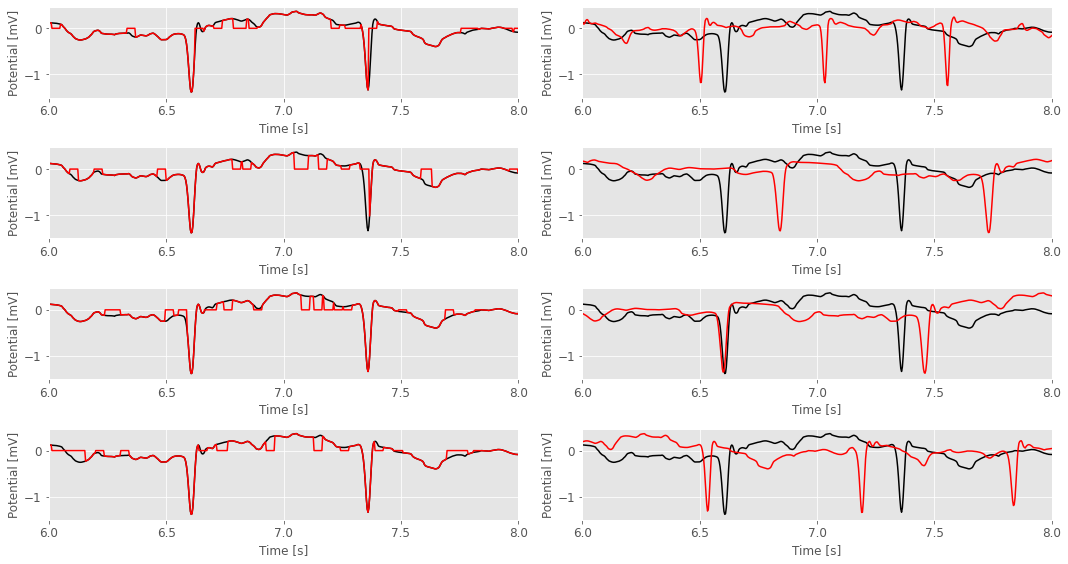

In [9]:
from physionet_processing import zero_filter, random_resample

data_zero = [] 
data_resampled = []
runs = 4

for i in range(runs):
    data_zero.append(zero_filter(np.expand_dims(ts_extended, axis = 0), threshold = 2, depth = 10)[0])
    data_resampled.append(random_resample(np.expand_dims(ts_extended, axis = 0))[0])

fig, axarr = plt.subplots(runs, 2, figsize = (15, 8))
x_lim = [6, 8] 
x_ticks = np.arange(x_lim[0], x_lim[1] + 0.5, 0.5)
x_label = 'Time [s]'
y_label = 'Potential [mV]'

for row in range(runs):
    
    ax = axarr[row, 0]
    ax.plot(time, ts_extended, 'k')
    ax.plot(time, data_zero[row], 'r')
    ax.set(xlim = x_lim, xticks = x_ticks)
    ax.set(xlabel = x_label, ylabel = y_label)
    
    ax = axarr[row, 1]
    ax.plot(time, ts_extended, 'k')
    ax.plot(time, data_resampled[row], 'r')
    ax.set(xlim = x_lim, xticks = x_ticks)
    ax.set(xlabel = x_label, ylabel = y_label)
    
for ax in np.ndarray.flatten(axarr):
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(12)

plt.tight_layout()
plt.show()
fig.savefig('physionet_augmentation.png', bbox_inches = 'tight', dpi = 150)

In [10]:
'Generates data for Keras'
def __init__(self, h5file, list_IDs, labels, batch_size = 32, dim = (178, 33), 
             nperseg = 64, noverlap = 32,
             n_channels=1, sequence_length = 5736,
             n_classes = 4, shuffle = True, augment = False):
    
    'Initialization'
    self.h5file = h5file
    self.list_IDs = list_IDs
    self.labels = labels
    self.batch_size = batch_size
    self.dim = dim
    self.nperseg = nperseg
    self.noverlap = noverlap
    self.n_channels = n_channels
    self.sequence_length = sequence_length
    self.n_classes = n_classes
    self.shuffle = shuffle
    self.augment = augment
    self.on_epoch_end()

In [11]:
def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' 
        X = np.empty((self.batch_size, *self.dim, self.n_channels), dtype = float)
        y = np.empty((self.batch_size), dtype = int)
        for i, ID in enumerate(list_IDs_temp):
            
            data = extend_ts(self.h5file[ID]['ecgdata'][:, 0], self.sequence_length)
            data = np.reshape(data, (1, len(data)))
        
            if self.augment:
            
                data = zero_filter(data, threshold = 2, depth = 10)
            
                data = random_resample(data)
            
            data_spectrogram = spectrogram(data, nperseg = self.nperseg, noverlap = self.noverlap)[2]
            data_norm = (data_spectrogram - np.mean(data_spectrogram))/np.std(data_spectrogram)
            X[i,] = np.expand_dims(data_norm, axis = 3)
            y[i] = self.labels[ID]

        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

In [12]:
from sklearn.preprocessing import LabelEncoder

label_df = pd.read_csv(label_file, header = None, names = ['name', 'label'])

label_set = list(sorted(label_df.label.unique()))
encoder = LabelEncoder().fit(label_set)
label_set_codings = encoder.transform(label_set)
label_df = label_df.assign(encoded = encoder.transform(label_df.label))

print('Unique labels:', encoder.inverse_transform(label_set_codings))
print('Unique codings:', label_set_codings)
print('Dataset labels:\n', label_df.iloc[100:110,])

Unique labels: ['A' 'N' 'O' '~']
Unique codings: [0 1 2 3]
Dataset labels:
        name label  encoded
100  A00101     A        0
101  A00102     A        0
102  A00103     O        2
103  A00104     N        1
104  A00105     N        1
105  A00106     ~        3
106  A00107     A        0
107  A00108     O        2
108  A00109     N        1
109  A00110     O        2


In [13]:
from sklearn.model_selection import train_test_split

test_split = 0.33
idx = np.arange(label_df.shape[0])
id_train, id_val, _, _ = train_test_split(idx, idx, 
                                         test_size = test_split,
                                         shuffle = True,
                                         random_state = 123)

partition = {'train': list(label_df.iloc[id_train,].name), 
             'validation': list(label_df.iloc[id_val,].name)}

labels = dict(zip(label_df.name, label_df.encoded))

In [14]:

max_length = sequence_length

sequence_length = sequence_length_max 
spectrogram_nperseg = 64
spectrogram_noverlap = 32 
n_classes = len(label_df.label.unique())
batch_size = 32

Sx_log = spectrogram(np.expand_dims(ts_extended, axis = 0),
                     nperseg = spectrogram_nperseg,
                     noverlap = spectrogram_noverlap,
                     log_spectrogram = True)[2]
dim = Sx_log[0].shape

In [28]:
from physionet_generator import DataGenerator

params = {'batch_size': batch_size,
          'dim': dim,
          'nperseg': spectrogram_nperseg,
          'noverlap': spectrogram_noverlap,
          'n_channels': 1,
          'sequence_length': sequence_length,
          'n_classes': n_classes,
          'shuffle': True}

train_generator = DataGenerator(h5file, partition['train'], labels, augment = True, **params)
val_generator = DataGenerator(h5file, partition['validation'], labels, augment = False, **params)

for i, batch in enumerate(train_generator):
    if i == 1:
        break

X = batch[0]
y = batch[1]

print('X shape:', X.shape)
print('y shape:', y.shape)
print('X type:', np.dtype(X[0,0,0,0]))

X shape: (32, 570, 33, 1)
y shape: (32, 4)
X type: float64


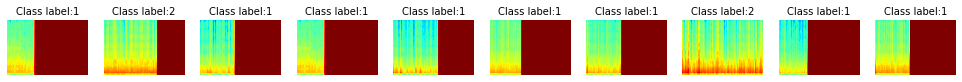

In [16]:
def imshow_batch(X, y, batch_idx):
    
    batch_labels = ['Class label:' + str(np.argmax(y[idx,])) for idx in batch_idx]

    fig, ax = plt.subplots(1, len(batch_idx), figsize = (17, 1))

    for i, idx in enumerate(batch_idx):
    
        ax[i].imshow(X[idx, :, :, 0].transpose(), cmap = 'jet', aspect = 'auto')
        ax[i].grid(False)
        ax[i].axis('off')
        ax[i].invert_yaxis()
        ax[i].set_title(batch_labels[i], fontsize = 10)
    
    plt.show()
        
    return fig

batch_idx = np.random.randint(0, batch_size, size = 10) 
fig = imshow_batch(X, y, batch_idx)
fig.savefig('physionet_Batch.png', bbox_inches = 'tight', dpi = 150)
plt.show()

In [17]:
def conv2d_block(model, depth, layer_filters, filters_growth, 
                 strides_start, strides_end, input_shape, first_layer = False):
    
    ''' Convolutional block. 
    depth: number of convolutional layers in the block (4)
    filters: 2D kernel size (32)
    filters_growth: kernel size increase at the end of block (32)
    first_layer: provide input_shape for first layer'''
    
    conv_parms = {'kernel_size': (3, 3),
                  'padding': 'same',
                  'dilation_rate': (1, 1),
                  'activation': None,
                  'data_format': 'channels_last',
                  'kernel_initializer': 'glorot_normal'}

    for l in range(depth):

        if first_layer:
            
            model.add(layers.Conv2D(filters = layer_filters,
                                    strides = strides_start,
                                    input_shape = input_shape, **conv_parms))
            first_layer = False
        
        else:
            if l == depth - 1:
                layer_filters += filters_growth
                model.add(layers.Conv2D(filters = layer_filters,
                                        strides = strides_end, **conv_parms))
            else:
                model.add(layers.Conv2D(filters = layer_filters,
                                        strides = strides_start, **conv_parms))
        
        model.add(layers.BatchNormalization(center = True, scale = True))
        model.add(layers.Activation('relu'))
    
    return model

In [18]:
n_channels = 1 
input_shape = (*dim, n_channels)
filters_start = 32 
layer_filters = filters_start
filters_growth = 32 
strides_start = (1, 1) 
strides_end = (2, 2) 
depth = 4 
n_blocks = 6 

In [19]:
model = Sequential()

for block in range(n_blocks):

    if block == 0:
        provide_input = True
    else:
        provide_input = False
    
    model = conv2d_block(model, depth,
                         layer_filters,
                         filters_growth,
                         strides_start, strides_end,
                         input_shape,
                         first_layer = provide_input)
    
    layer_filters += filters_growth

In [20]:
# Define temporal feature avaraging layer
def MeanOverTime():
    lam_layer = layers.Lambda(lambda x: K.mean(x, axis=1), output_shape=lambda s: (1, s[2]))
    return lam_layer

model.add(layers.Reshape((-1, 224)))
model.add(layers.core.Masking(mask_value = 0.0))
model.add(MeanOverTime())

model.add(layers.Dense(4, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 570, 33, 32)       320       
_________________________________________________________________
batch_normalization (BatchNo (None, 570, 33, 32)       128       
_________________________________________________________________
activation (Activation)      (None, 570, 33, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 570, 33, 32)       9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 570, 33, 32)       128       
_________________________________________________________________
activation_1 (Activation)    (None, 570, 33, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 570, 33, 32)       9

In [24]:
import tensorflow
model.compile(loss='categorical_crossentropy',
              optimizer=tensorflow.keras.optimizers.Adam(lr=0.001),
              metrics=['acc'])

C:\Users\saibh\anaconda3\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [25]:
history = model.fit_generator(generator = train_generator,
                              steps_per_epoch = 100,
                              epochs = 50,
                              validation_data = val_generator,
                              validation_steps = 50)

C:\Users\saibh\anaconda3\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
100/100 [==============================] - 268s 3s/step - loss: 1.0254 - acc: 0.5731 - val_loss: 1.1582 - val_acc: 0.5688
Epoch 2/50
100/100 [==============================] - 265s 3s/step - loss: 0.9603 - acc: 0.5962 - val_loss: 1.4260 - val_acc: 0.1225
Epoch 3/50
100/100 [==============================] - 264s 3s/step - loss: 0.9502 - acc: 0.5969 - val_loss: 3.9693 - val_acc: 0.5750
Epoch 4/50
100/100 [==============================] - 265s 3s/step - loss: 0.9064 - acc: 0.6116 - val_loss: 3.1100 - val_acc: 0.5969
Epoch 5/50
100/100 [==============================] - 268s 3s/step - loss: 0.8788 - acc: 0.6266 - val_loss: 1.3886 - val_acc: 0.5850
Epoch 6/50
100/100 [==============================] - 266s 3s/step - loss: 0.8539 - acc: 0.6406 - val_loss: 1.7511 - val_acc: 0.5894
Epoch 7/50
100/100 [==============================] - 269s 3s/step - loss: 0.8336 - acc: 0.6475 - val_loss: 3.1382 - val_acc: 0.5931
Epoch 8/50
100/100 [==============================] - 267s 3s/step - 

In [26]:
model.save('2D-CNN')

INFO:tensorflow:Assets written to: 2D-CNN\assets


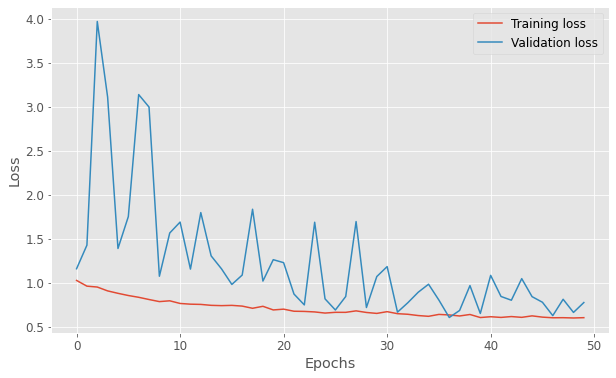

In [29]:
plt.figure(figsize = (10,6))
hist_loss = history.history['loss']
hist_val_loss = history.history['val_loss']

plt.plot(hist_loss, label='Training loss')
plt.plot(hist_val_loss, label='Validation loss')

plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

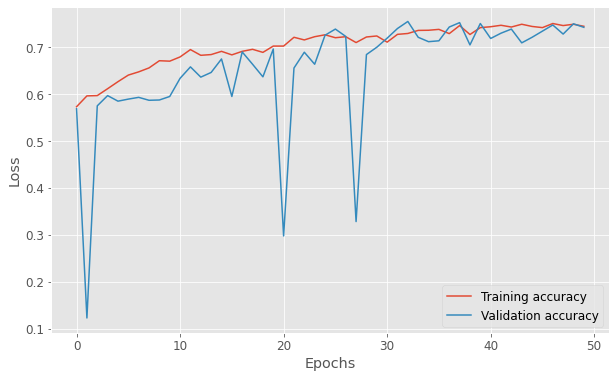

In [32]:
# visualize accuracy for the training
plt.figure(figsize = (10,6))
hist_loss = history.history['acc']
hist_val_loss = history.history['val_acc']

plt.plot(hist_loss, label='Training accuracy')
plt.plot(hist_val_loss, label='Validation accuracy')

plt.legend(loc='lower right')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()